In [1]:
import requests
from tqdm import tqdm
import pandas as pd
from shapely.ops import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import io
from pathlib import Path

In [2]:
URL = 'https://waterservices.usgs.gov/nwis/site/'

In [3]:
tile_name = 'NH15'
tile_dir = Path(f'out/{tile_name}')
tile_dir.exists()

True

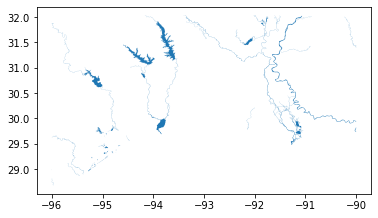

In [4]:
df_channel = gpd.read_file(tile_dir/f'channel_mask_{tile_name}').to_crs({'init': 'epsg:4326'})
df_channel.plot()

In [5]:
bounds = df_channel.total_bounds
bounds = [f'{b:1.2f}' for b in bounds]
bounds

['-96.00', '28.68', '-90.00', '32.04']

# 1 - Get all Stations with Width Parameter code

We search the codes using: https://help.waterdata.usgs.gov/codes-and-parameters/parameters or you can search the all the codes at once [here](https://help.waterdata.usgs.gov/code/parameter_cd_query?fmt=rdb&inline=true&group_cd=%).

We start with a sample

In [6]:
# Width code: 00004
# Other width codes: 72331 (meters), 04121 (horizonta width, ft)
# All codes: https://help.waterdata.usgs.gov/code/parameter_cd_query?fmt=rdb&inline=true&group_cd=%


PARAMETER_CODE = '00004'
PARAMETER_DICT = {'00004': 'width_ft'}
PARAMETER_STRING = PARAMETER_DICT[PARAMETER_CODE]

print(f'Getting parameter {PARAMETER_STRING}')

payload = dict(format='rdb',#,1.0',
               bBox=','.join(bounds),
               parameterCd=PARAMETER_CODE,
               siteStatus='all',
               # This is for daily values.
               #hasDataTypeCd='dv,iv', # daily values
              )
r = requests.get(URL, params=payload)

Getting parameter width_ft


In [7]:
# the io portion ensures the usgs output format 
# can be parsed by pandas into a python dataframe in memory
df_stations = pd.read_csv(io.StringIO(r.content.decode('utf-8')), delimiter='\t', comment='#')
df_stations = df_stations.iloc[1:]
print(df_stations.shape)
df_stations.head()

(68, 12)


,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd
1,USGS,07291000,"HOMOCHITTO RIVER AT EDDICETON, MS",ST,31.50305556,-90.7775,5,NAD83,212.22,0.1,NGVD29,08060205
2,USGS,07292500,"HOMOCHITTO RIVER AT ROSETTA, MS",ST,31.3247222,-91.1094444,5,NAD83,94.39,0.1,NGVD29,08060205
3,USGS,07373420,"MISSISSIPPI R NR ST. FRANCISVILLE, LA",ST,30.75851659,-91.3959464,U,NAD83,NaN,NaN,NaN,08070100
4,USGS,07375050,"Tchefuncte River near Covington, LA",ST,30.4946364,-90.1695244,S,NAD83,0.00,0.1,NAVD88,08090201
5,USGS,07375170,"Bogue Falaya at Covington, LA",ST,30.49963635,-90.0845216,S,NAD83,0.00,0.5,NAVD88,08090201


In [8]:
df_stations.loc[:,'dec_long_va'] = pd.to_numeric(df_stations['dec_long_va'].values)
df_stations.loc[:,'dec_lat_va'] = pd.to_numeric(df_stations['dec_lat_va'].values)

def pointify(row):
    return Point(row['dec_long_va'], row['dec_lat_va'])

df_stations.dropna(subset=['dec_long_va', 'dec_lat_va'], inplace=True)
geometry = df_stations.apply(pointify, axis=1)

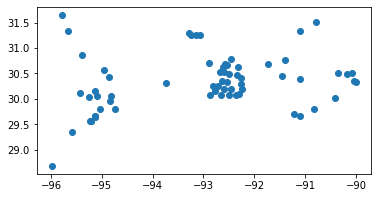

In [9]:
df_stations = gpd.GeoDataFrame(df_stations,
                               geometry=geometry,
                               crs={'init': 'epsg:4326'})
df_stations.dropna(subset=['geometry'],
                   inplace=True)
df_stations.plot()

In [10]:
df_stations = gpd.sjoin(df_stations,
                        df_channel,
                        how='inner',
                        op='intersects')

(13, 15)


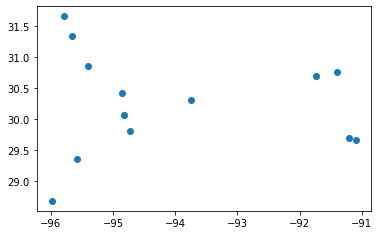

In [11]:
print(df_stations.shape)
df_stations.plot()

## Get Heights

We use the API calls from the [Water Quality Data](https://www.waterqualitydata.us/portal/), which is what the USGS site directs us to for physical measurements.

Here is a sample.

In [12]:
URL_WQ = 'https://www.waterqualitydata.us/data/Result/search?'
site_no = '07374525'
payload = {'siteid': f'USGS-{site_no}',
           'pCode': '00004',
           'mimeType': 'csv',
           'zip': 'no',
           'dataProfile': 'narrowResult'
           }
r = requests.get(URL_WQ, params=payload)
r.url, r.status_code
df_heights = pd.read_csv(io.StringIO(r.content.decode('utf-8')))
df_heights.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,USGS-LA,USGS Louisiana Water Science Center,nwisla.01.01900002,2018-10-16,11:00:00,CDT,USGS-07374525,NWIS-112140156,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-LA,USGS Louisiana Water Science Center,nwisla.01.01900037,2018-12-04,11:00:00,CST,USGS-07374525,NWIS-115620601,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-LA,USGS Louisiana Water Science Center,nwisla.01.01800179,2018-06-19,11:00:00,CDT,USGS-07374525,NWIS-111291548,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-LA,USGS Louisiana Water Science Center,nwisla.01.02000322,2020-06-23,11:00:00,CDT,USGS-07374525,NWIS-119201838,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-LA,USGS Louisiana Water Science Center,nwisla.01.01900291,2019-07-09,11:00:00,CDT,USGS-07374525,NWIS-117261309,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


The important column is `ResultMeasureValue` in `ft`.

In [13]:
df_heights['ResultMeasureValue'].head()

0    2410
1    2480
2    2480
3    2640
4    2640
Name: ResultMeasureValue, dtype: int64

In [14]:
def get_station_width_stats(site_no):
    payload = {'siteid': f'USGS-{site_no}',
               'pCode': '00004',
               'mimeType': 'csv',
               'zip': 'no',
               'dataProfile': 'narrowResult'
               }
    r = requests.get(URL_WQ, params=payload)
    df_heights = pd.read_csv(io.StringIO(r.content.decode('utf-8')))
    heights = df_heights.ResultMeasureValue.values * 0.3048
    return heights.mean(), heights.std(), len(heights), heights.min(), heights.max()

In [15]:
temp = df_stations.site_no.map(get_station_width_stats)
(df_stations['width_mean'],
 df_stations['width_std'], 
 df_stations['width_count'],
 df_stations['width_min'],
 df_stations['width_max']) = zip(*temp)
df_stations.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,geometry,index_right,label,width_mean,width_std,width_count,width_min,width_max
3,USGS,07373420,"MISSISSIPPI R NR ST. FRANCISVILLE, LA",ST,30.758517,-91.395946,U,NAD83,NaN,NaN,NaN,08070100,POINT (-91.3959464 30.75851659),30,1,1518.224842,2215.672987,19,908.304,10911.840
10,USGS,073814675,"Bayou Boeuf at Railroad Bridge at Amelia, LA",ST,29.668333,-91.099722,S,NAD83,0.00,.01,NAVD88,08090302,POINT (-91.0997222 29.66833333),30,1,186.415680,3.624942,25,179.832,195.072
11,USGS,07381495,"(COE) Atchafalaya River at Melville, LA",ST,30.690743,-91.736226,S,NAD83,NaN,NaN,NaN,08080101,POINT (-91.7362262 30.690743),30,1,428.752000,25.093349,27,374.904,481.584
12,USGS,07381600,"Lower Atchafalaya River at Morgan City, LA",ST,29.692819,-91.211937,S,NAD83,-0.45,.01,NAVD88,08080101,POINT (-91.2119368 29.69281939),30,1,556.895000,43.600600,24,509.016,755.904
29,USGS,08030500,"Sabine Rv nr Ruliff, TX",ST,30.303817,-93.743778,F,NAD83,-5.92,.1,NGVD29,12010005,POINT (-93.74377840000001 30.30381684),19,1,80.238600,3.993782,44,76.200,86.868


## Save and Plot Station Figure

In [16]:
df_stations = df_stations[~df_stations.station_nm.str.contains('Matagorda')].copy()

In [17]:
PLOT_DIR = Path('plot/')
PLOT_DIR.mkdir(exist_ok=True)

In [18]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=25)

In [19]:
names = df_stations.station_nm.tolist()
names

['MISSISSIPPI R NR ST. FRANCISVILLE, LA',
 'Bayou Boeuf at Railroad Bridge at Amelia, LA',
 '(COE) Atchafalaya River at Melville, LA',
 'Lower Atchafalaya River at Morgan City, LA',
 'Sabine Rv nr Ruliff, TX',
 'Trinity Rv nr Oakwood, TX',
 'Trinity Rv nr Crockett, TX',
 'Trinity Rv at Riverside, TX',
 'Trinity Rv at Romayor, TX',
 'Trinity Rv at Liberty, TX',
 'Old Rv Cutoff at Buckeye Island nr Anahuac, TX',
 'Brazos Rv nr Rosharon, TX']

In [20]:
rename = ['St. Francisville, LA',
          'Bayou Boeuf, LA',
          'Melville, LA',
          'Morgan City, LA',
          'Ruliff, TX',
          'Oakwood, TX',
          'Crockett, TX',
          'Riverside, TX',
          'Romayor, TX',
          'Liberty, TX',
          'Anahuac, TX',
          'Rosharon, TX',
          'Matagorda, TX']
rename_dict = {n: rn for n, rn in zip(names, rename)}
df_stations['station_name_manual'] = df_stations['station_nm'].map(lambda name: rename_dict.get(name, ''))

In [21]:
df_stations.to_file(tile_dir/f'{PARAMETER_STRING}_{tile_name}_station.geojson', driver='GeoJSON')

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


/Users/cmarshak/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


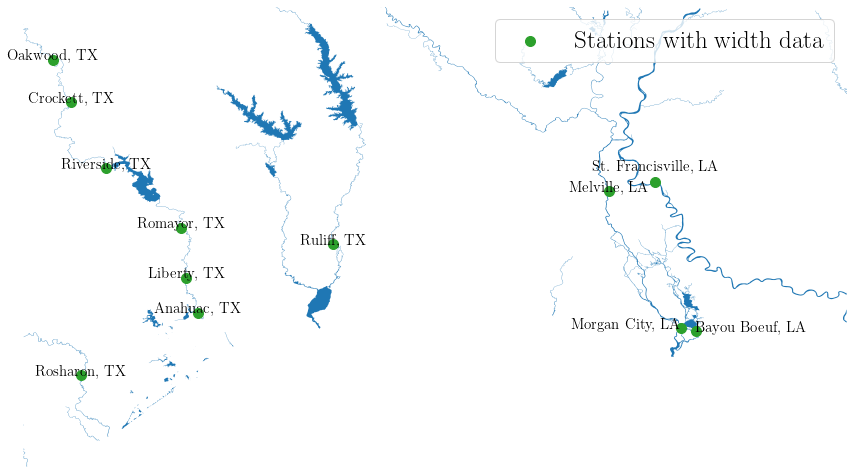

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))

df_channel.plot(ax=ax)
df_stations.plot(ax=ax, 
                 column='parameter_name', 
                 markersize=100,
                 color='tab:green',
                 label='Stations with width data')

xmin, ymin, xmax, ymax = df_channel.total_bounds
ax.axis((xmin - .1, xmax, ymin, ymax))
plt.legend()

for idx, row in df_stations.iterrows():
    
    s = row['station_name_manual']
    
    k = .4
    fs = 15
    if 'Morgan' in s:
        ax.annotate(s=s, 
                    xy=(row['geometry'].coords[:][0][0] - k, row['geometry'].coords[:][0][1]),
                    horizontalalignment='center', 
                    c='black',
                    fontsize=fs)
    elif 'St.' in s:
        ax.annotate(s=s, 
                    xy=(row['geometry'].coords[:][0][0], row['geometry'].coords[:][0][1] + k/5),
                    horizontalalignment='center', 
                    c='black',
                    fontsize=fs)
    elif 'Bayou' in s:
        ax.annotate(s=s, 
                    xy=(row['geometry'].coords[:][0][0] + k, row['geometry'].coords[:][0][1]),
                    horizontalalignment='center', 
                    c='black',
                    fontsize=fs)
    else:
        ax.annotate(s=s, 
                    xy=row['geometry'].coords[:][0],
                    horizontalalignment='center', 
                    c='black',
                    fontsize=fs)

ax.axis('off')
plt.savefig(PLOT_DIR/'stations.png')